# Correct Jets

How often does my selection of the four jets get the ones originating from the b-quarks?

I'm interested to know these numbers so I have an intuition for how often the pairing algorithm get the correct HCs, but I don't think this plot will make sense to make unless I have an intuition for whether the jets are even correct or not.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import glob
import uproot

import os
import sys
sys.path.append("../code")
from analysis import read_tsv, fileDir, triggers, yr_short
from plotting import varEvolution, massPlane
from eventDisplays import truthInfo

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.



<img src="../figures/to-do-4goodJets.png" />


## Load in the data... and all that jazz

In [3]:
physicsSample = 'SMNR'
prodTag = 'AUG2019'

prodTag = "AUG2019"
subDir = f"{physicsSample}_mc16a_PFlow-{prodTag}"
figDir = f"../figures/{subDir}"

In [6]:
miniNtuple = pd.read_hdf(f"../data/{subDir}/df_f_0.22.h5",key='df')

In [2]:
# physicsSample = 'SMNR'
# run_one = True
# trigger = '2016_triggers'

In [3]:
# if 'triggers' in trigger:
#     subDir = '{}_{}'.format(physicsSample,yr_short[int(trigger[:4])])
# else:
#     for year in [2015,2016]:
#         if trigger in triggers[year]:
#             subDir = '{}_{}'.format(physicsSample,yr_short[year])

# if 'triggers' in trigger:
#     triggerText = trigger.replace("_"," ")
#     varRange = (0,200)
# else:
#     triggerText = trigger
#     varRange = (0,400)
        
# figDir = "../figures/{}/{}".format(subDir,trigger)

In [4]:
# fDir = "../data/{}_PFlow/".format(physicsSample)
# if run_one:
#     fName = "files/df_f_0.22_000001.h5" # for lower stats
# else:
#     fName = "files/df_f_0.22_00*.h5"

In [5]:
# myFiles = fDir + fName
# dfs = []
# tdfs = []

# for i, myFile in enumerate(glob.glob(myFiles)):

#     print('{}. {}'.format(i+1,myFile))
    
#     df = pd.read_hdf(myFile,key='df')
#     #dfs.append(df.query(trigger).query('fourGoodJets').query('nbtags >= 4'))
#     loadMask = df.fourGoodJets & (df.nbtags >= 4) & df[trigger]
#     dfs.append(df.loc[loadMask,df.columns])
#     tdfs.append(df.loc[df[trigger],df.columns])
    
# miniNtuple = pd.concat(dfs)
# trigOnly = pd.concat(tdfs)

1. ../data/SMNR_PFlow/files/df_f_0.22_000001.h5


### Step 1: Plot the $p_T$ distribution for the truth $b$-quarks

Note: I've looked at this plot already in the `old-Studies/SM-Truth-Pairing` notebook, so what's different now is that I am looking at the analysis at an earlier snap shot, but also with the triggers applied.

The triggers could encourage only events with higher $p_T$ $b$-quarks to be considered. But also, I saw a lot of the times the pairing algorithm was wrong because we had one of the $b$-quarks didn't have high enough $p_T$ to be one of the selected $b$-jets, so this means these truth quarks could also have lower $p_T$... I'll be interested to see the results of this plot!

In [13]:
baseFigName = 'fourGoodJets'
my_title = 'SM NR: Selecting 4 good b-jets'

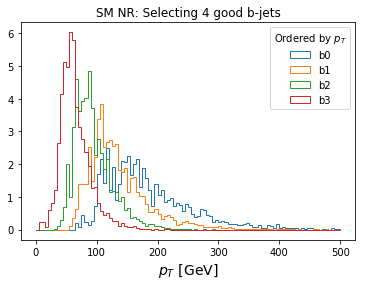

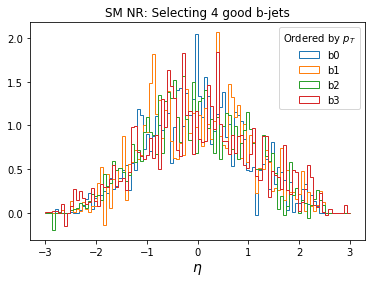

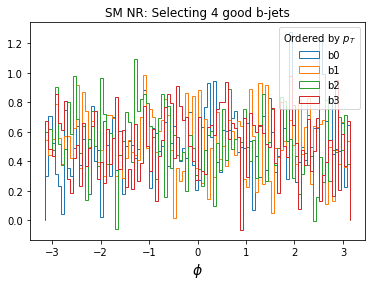

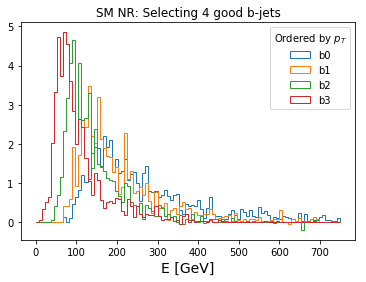

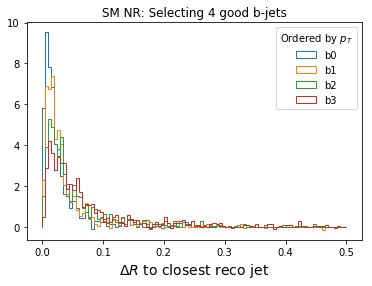

In [6]:
for var, nBins, myRange, xlabel in zip(['pt','eta','phi','E','drMatch'], [100]*5,
                                      [(0,500),(-3,3),(-np.pi,np.pi),(0,750),(0,0.5)],
                                      ['$p_T$ [GeV]','$\eta$','$\phi$','E [GeV]','$\Delta R$ to closest reco jet']):
    
    plt.figure()
    
    for ib in range(4):
        
        key = 'b{}_{}'.format(ib,var)
        plt.hist(miniNtuple[key], bins=nBins, range=myRange,
                 histtype='step', label='b{}'.format(ib),
                 weights=miniNtuple['mcEventWeight'])
                
    plt.legend(title='Ordered by $p_T$')
    plt.xlabel(xlabel,fontsize=14)
    plt.title(my_title)
    if var != 'jidx':
        plt.savefig('{}/truth/b_{}.pdf'.format(figDir,var))
    
plt.show()

**What's the intuition we've gained?**

These are the truth distributions of the events that *passed* the first cut, so that's why the $p_T$ of the b-quarks is so high.


Something else that I found interesting looking at this plot was that it was almost always the softest $b$-quark that has the highest opening angle.

At first I foud this counter-intutive since the higher $p_T$ $b$-quark will radiate more (radiation $\sim Q^2$), so I thought this extra radiation could be more likely to throw the jet off-axis. But turns out, I think this does make sense, and it's just saying that it's harder to kick a high momentum object, it's just basic Newtonian mechanics.


**Correct jets definition**

So, to say the event got the wrong 4-jets, I'll say if this angle is larger than 0.3, harkening back to the FTAG truth labelling definition.

In [8]:
dr_max = np.max(miniNtuple[['b{}_selJet_drMatch'.format(i) for i in range(4)]].values,axis=1)

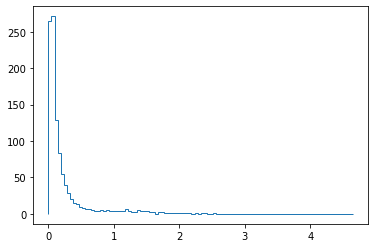

In [9]:
n, edg, _ = plt.hist(dr_max,bins=100,histtype='step',weights=miniNtuple.mc_sf)
plt.show()

In [10]:
matchEff = np.add.accumulate(n) / np.sum(n)

In [12]:
figDir

'../figures/SMNR_mc16a_PFlow-AUG2019'

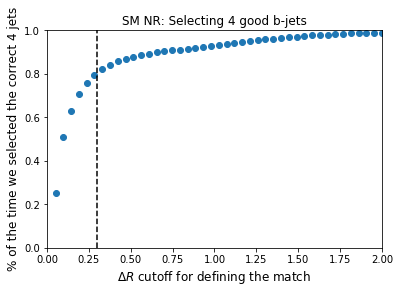

In [15]:
plt.scatter(edg[1:],matchEff)

Rmatch = 0.3
plt.plot([Rmatch]*2,[0,1],'k--')

plt.xlim(0,2)
plt.ylim(0,1)

plt.xlabel('$\Delta R$ cutoff for defining the match',fontsize=12)
plt.ylabel('% of the time we selected the correct 4 jets',fontsize=12)
plt.title(my_title)
plt.savefig('{}/dRcutoff.pdf'.format(figDir))

plt.show()


In [16]:
eff = np.sum(miniNtuple.loc[dr_max < Rmatch,'mc_sf']) / np.sum(miniNtuple['mc_sf'])

print('% of time we get the right 4-jets: {}'.format(eff))

% of time we get the right 4-jets: 0.8081925380044819


So this number is saying that for events that passed the trigger, and had four b-tagged jets with $p_T > $ 40 GeV and $|\eta| < 2.5$, 80% of the time this cut gave us the right reco quarks. 

It's interesting that we have this category of events we would *never* pair correctly because we already selected the *wrong* four jet.

I'm going to plot the probability that we have the correct 4-jets as a function of where we are in the analysis!

I expect this number to increase as we go apply subsequent analysis steps.

In [17]:
x = ['4 b-jets $p_T > 40$ GeV, $|\eta| < 2.5$',
     'MD $\Delta R_{jj}$', 'MD $p_T(h)$s',
     '$|\Delta \eta_{hh}| < 1.5$','$X_{wt} > 1.5$',
     '$X_{hh}$ < 1.6']

masks = [miniNtuple.fourGoodJets, miniNtuple.MDR, 
         miniNtuple.MDpT, miniNtuple.cut_deta_hh,
         miniNtuple.cut_Xwt, miniNtuple.cut_Xhh]

counts = [np.sum(miniNtuple.loc[mask & (dr_max < Rmatch),'mc_sf']) / np.sum(miniNtuple.loc[mask,'mc_sf']) for mask in masks]

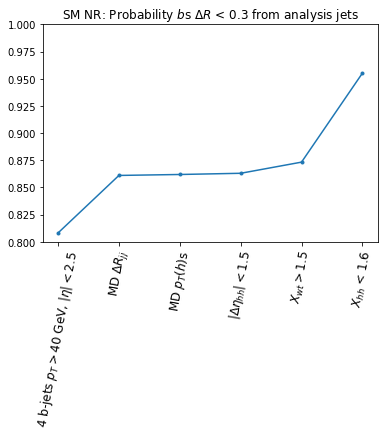

In [18]:
plt.plot(range(len(x)),counts,color='C0',marker='.')
plt.xticks(range(len(x)),x,rotation=80,fontsize=12)
plt.ylim(0.8,1)
plt.title('SM NR: Probability $b$s $\Delta R$ < 0.3 from analysis jets')
plt.show()

However, the about figure does not take into account the fact that we could have two $b$-quarks $\Delta R$ matching to the *same* reco jets.

Let's make one more version of this figure!

In [19]:
jetMatches = np.array([ np.max(np.unique(indices.values,return_counts=True)[1]) \
                       for ievt, indices in miniNtuple[['b{}_selJet_jidx'.format(i) for i in range(4)]].iterrows()])

goodJets = (dr_max < Rmatch) & (jetMatches == 1)

In [20]:
goodJets_cts = [np.sum(miniNtuple.loc[mask & goodJets,'mc_sf']) / np.sum(miniNtuple.loc[mask,'mc_sf']) for mask in masks]

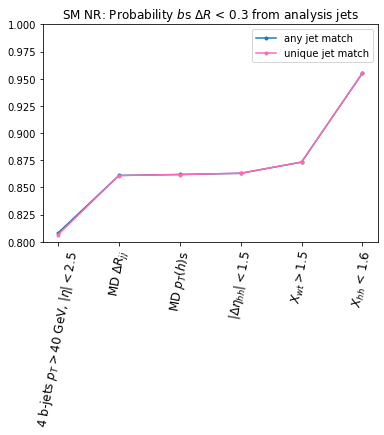

In [21]:
plt.plot(range(len(x)),counts,color='C0',marker='.',label='any jet match')
plt.plot(range(len(x)),goodJets_cts,color='hotpink',marker='.',label='unique jet match')
plt.xticks(range(len(x)),x,rotation=80,fontsize=12)
plt.ylim(0.8,1)
plt.legend()
plt.title('SM NR: Probability $b$s $\Delta R$ < 0.3 from analysis jets')
plt.show()

They're practically on top of each other, which is good, and also sort of a motivation for doing the SM NR analysis in the resolved regime.

And then I'll also need to quantify what I mean by a "correct" pairing. I sort of side-stepped the issue in my `Pariring-Kinematics` notebook, but I should come back to this later.

### Step 2: Why are we loosing acceptance so much by this "good jets" cut?  

Maybe a good initial step would be to overlay the blue figure above with on showing how often we are $\Delta R$ matching the quarks to *any* of the reco jets.

In [22]:
any_dr_max = np.max(miniNtuple[['b{}_drMatch'.format(i) for i in range(4)]].values,axis=1)

anyJetMatches = np.array([ np.max(np.unique(indices.values,return_counts=True)[1]) \
                       for ievt, indices in miniNtuple[['b{}_jidx'.format(i) for i in range(4)]].iterrows()])

anyJets = (any_dr_max < Rmatch) & (anyJetMatches == 1)


anyJet_cts = [np.sum(miniNtuple.loc[mask & anyJets,'mc_sf']) / np.sum(miniNtuple.loc[mask,'mc_sf']) for mask in masks]


In [23]:
# It looks like all these matches are unique
y=  [np.sum(miniNtuple.loc[mask & (any_dr_max < Rmatch),'mc_sf']) / np.sum(miniNtuple.loc[mask,'mc_sf']) for mask in masks]

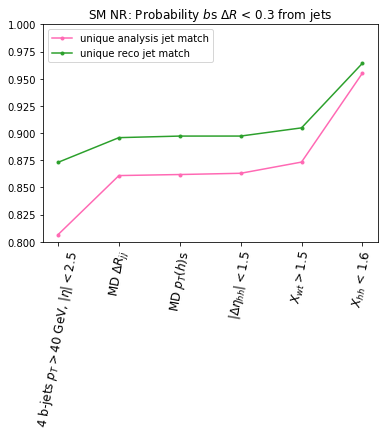

In [25]:
#plt.plot(range(len(x)),counts,color='C0',marker='.',label='any jet match')
plt.plot(range(len(x)),goodJets_cts,color='hotpink',marker='.',label='unique analysis jet match')
plt.plot(range(len(x)),anyJet_cts,color='C2',marker='.',label='unique reco jet match')
#plt.plot(range(len(x)),y,color='C4',marker='.',label='any reco jet match')
plt.xticks(range(len(x)),x,rotation=80,fontsize=12)
plt.ylim(0.8,1)
plt.legend(loc='upper left')
plt.title('SM NR: Probability $b$s $\Delta R$ < 0.3 from jets')
plt.savefig('{}/jetMatch.pdf'.format(figDir),
            bbox_inches='tight')
plt.show()

**Lessons:** From this plot, we can see that for half of the cases where the four jets cut got the wrong four $b$-jets, there were other jets in the event where we *could* have gotten the right ones.

But I just made this plot sort-of to probe my intuition, I don't think it's really the one that I want to focus on for my follow-up studies.

**Game plan:** Understand *why* we're loosing events with this four jets cut.

I think this could come from:
1. One of the jets is below the $p_T$ threshold
2. We had multiple b-tags, and picked up the wrong one
3. One of the jets (or quarks) was outside of the detector acceptance.





### Category 1: Fails 4 good b-jets cut and didn't have four $ p_T$ > 20 GeV, $|\eta|$ < 2.5 calo jets

For this category, we'll have to do something *crazy* to recover, but I think the first step is just to ID what types of events are failing.

**Question:** How often do the $b$-quarks passing the trigger, but failing the four good jets selection match to *any* of our reco jets?

In [20]:
any_dr_max = np.max(trigOnly[['b{}_drMatch'.format(i) for i in range(4)]].values,axis=1)

anyJetMatches = np.array([ np.max(np.unique(indices.values,return_counts=True)[1]) \
                       for ievt, indices in trigOnly[['b{}_jidx'.format(i) for i in range(4)]].iterrows()])

reco_match = (any_dr_max < Rmatch) & (anyJetMatches == 1)

In [21]:
first_cut = trigOnly.fourGoodJets & (trigOnly.nbtags == 4)

In [22]:
num = np.sum(trigOnly.loc[(~first_cut) & ~reco_match,'mc_sf'])
den = np.sum(trigOnly.loc[(~first_cut),'mc_sf'])
noRecoJet_loss = num / den

print('For {:.2f}% of the events that failed four good b-jets that didn\'t match to a reco jet'.format(noRecoJet_loss*100))

For 53.57% of the events that failed four good b-jets that didn't match to a reco jet


#### Event Displays!

I think the same event display that I was using for events *failing* the trigger should work here as well.

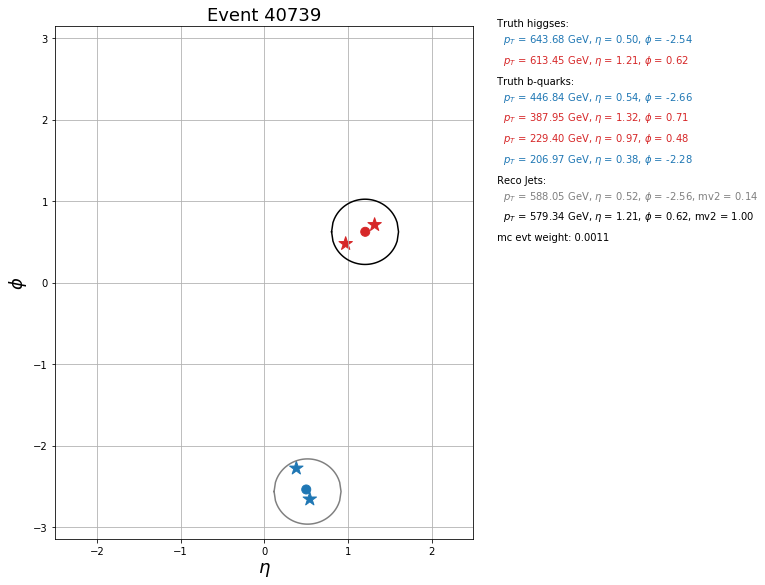

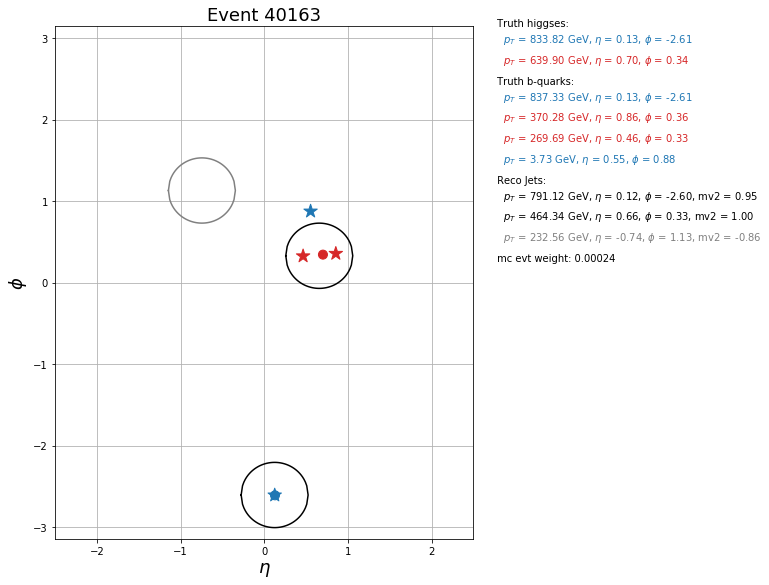

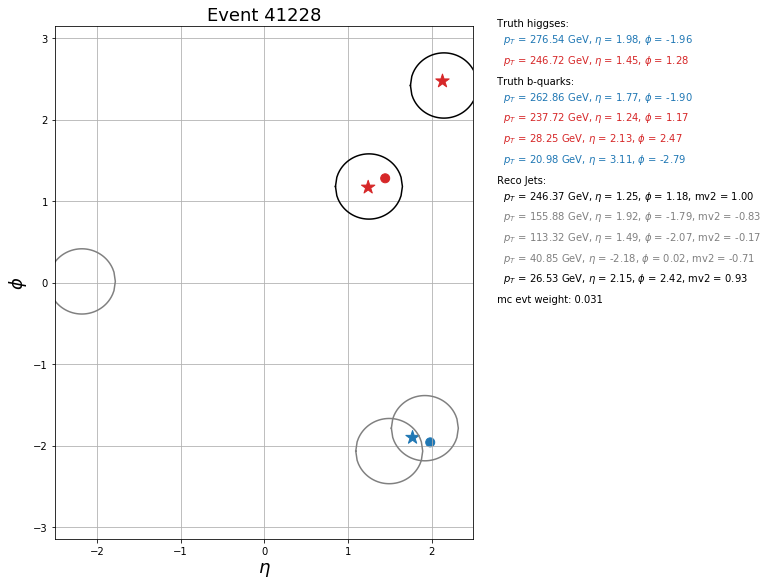

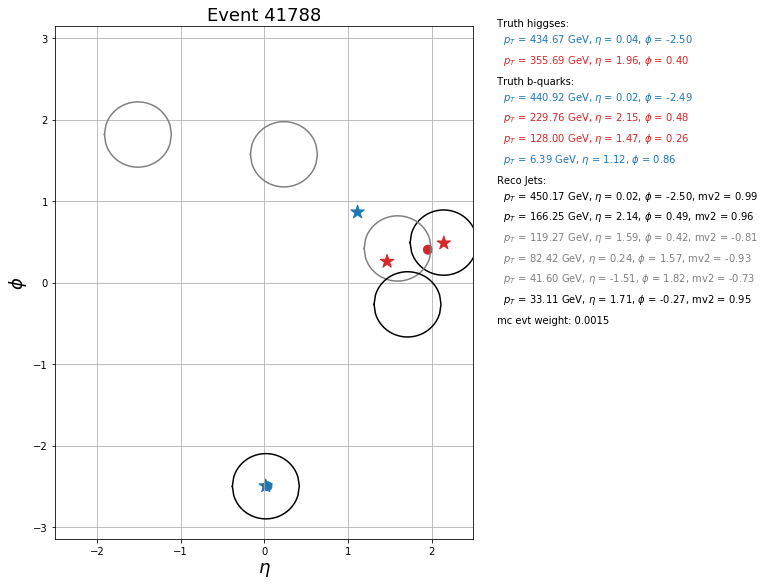

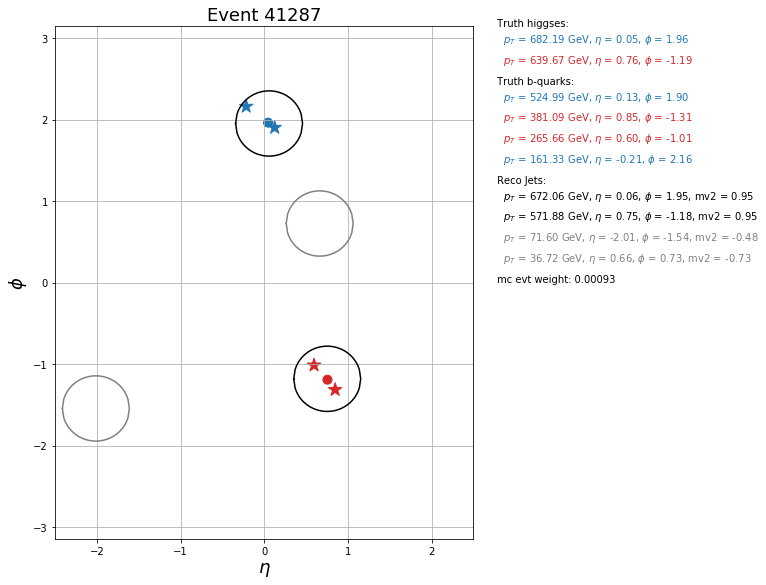

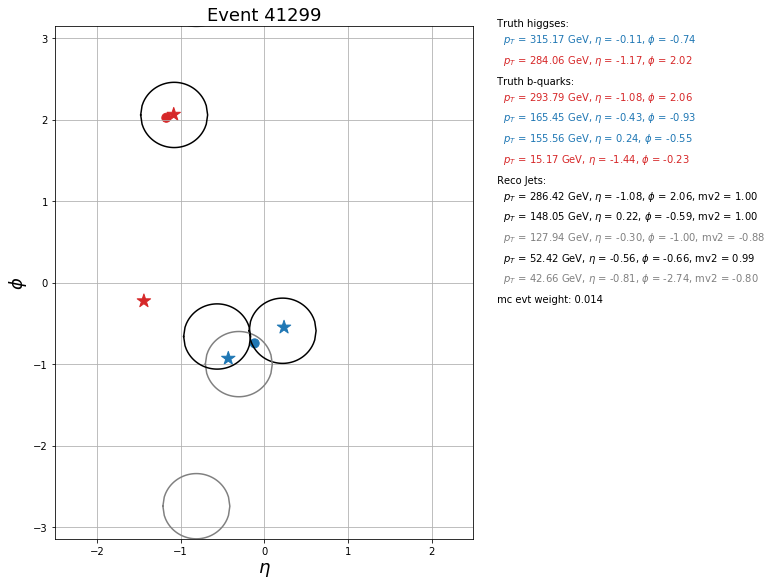

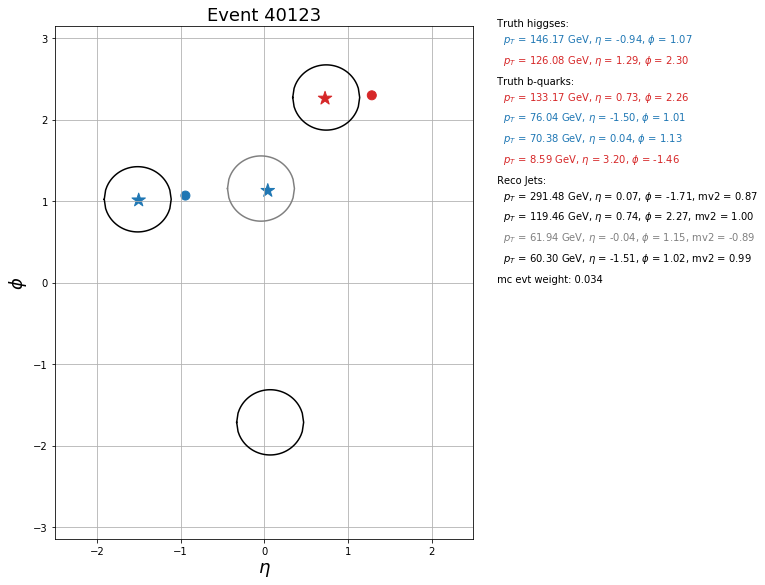

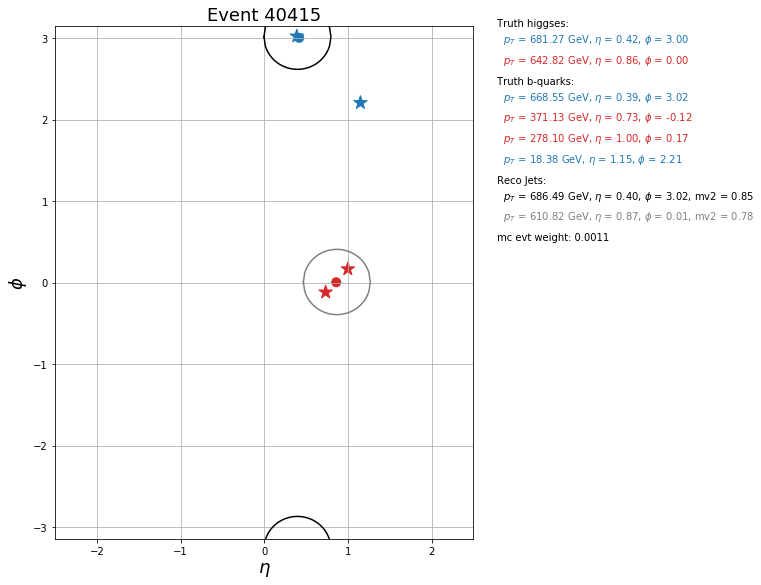

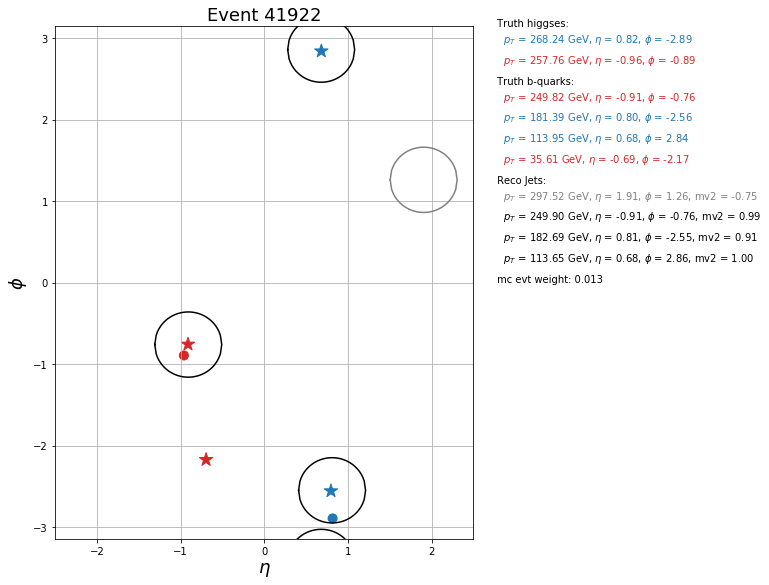

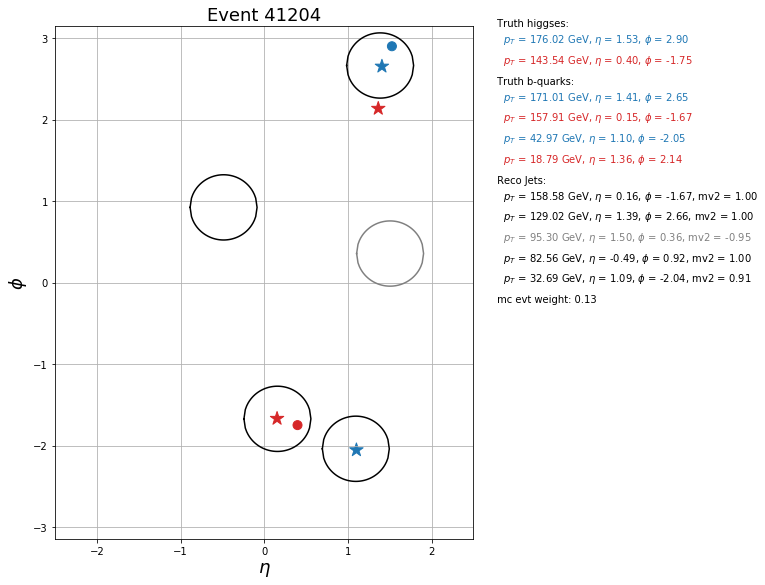

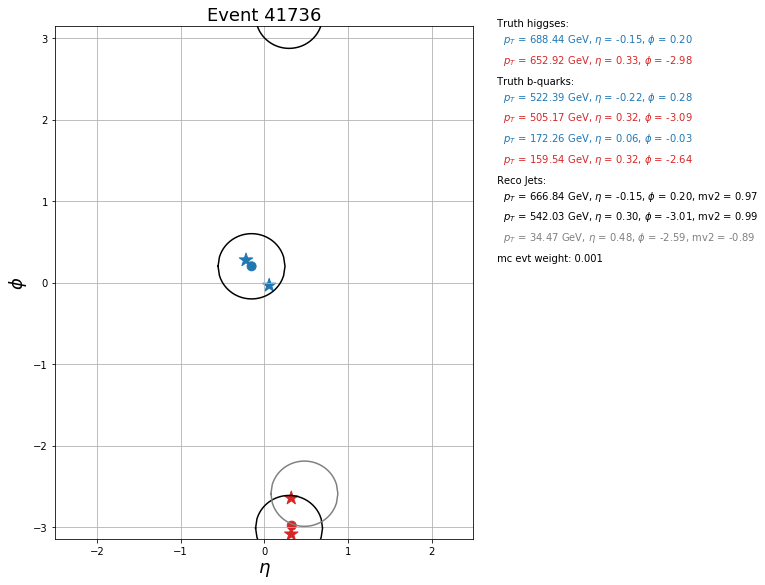

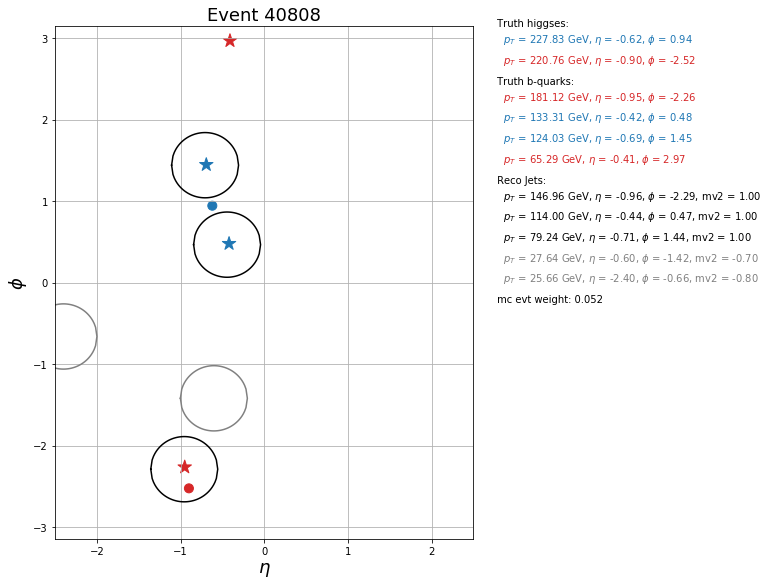

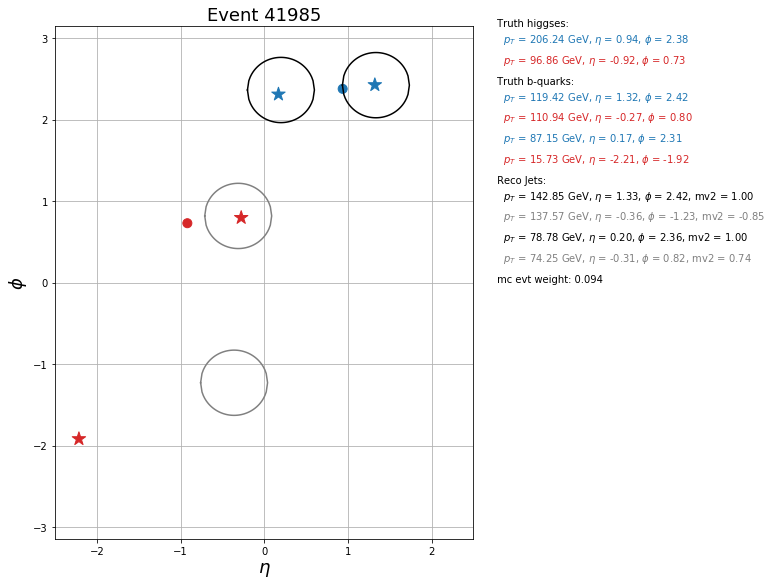

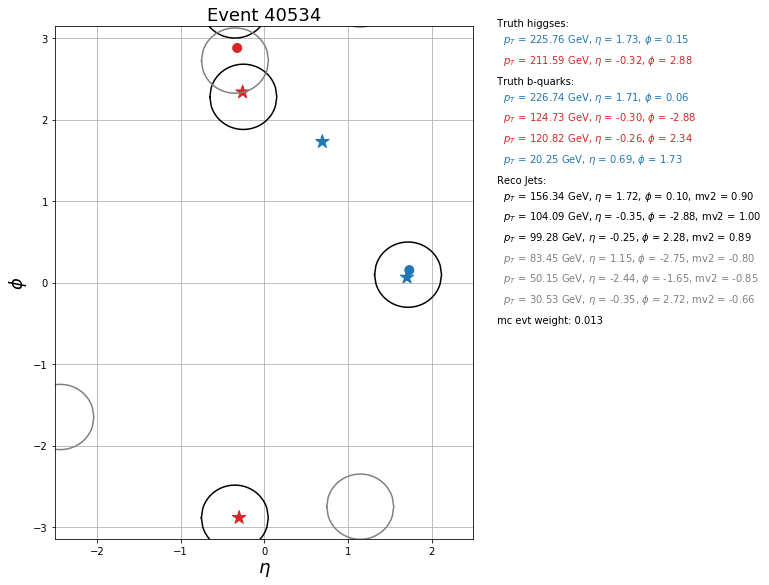

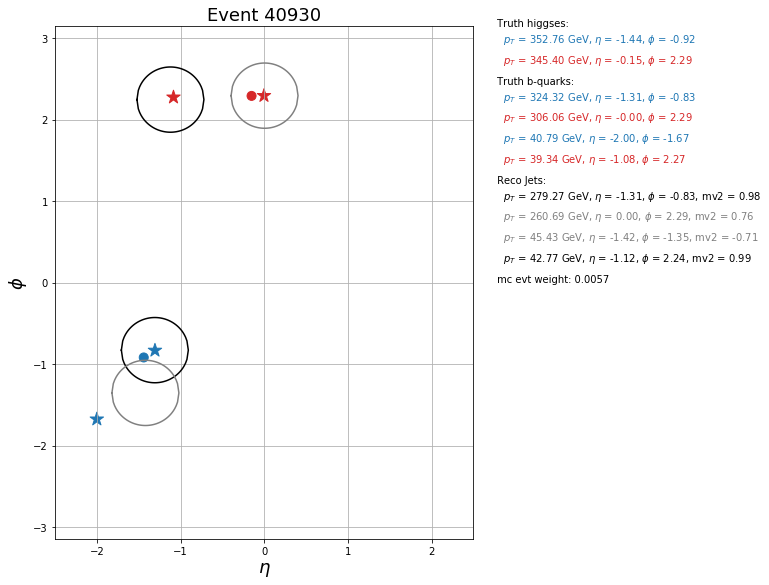

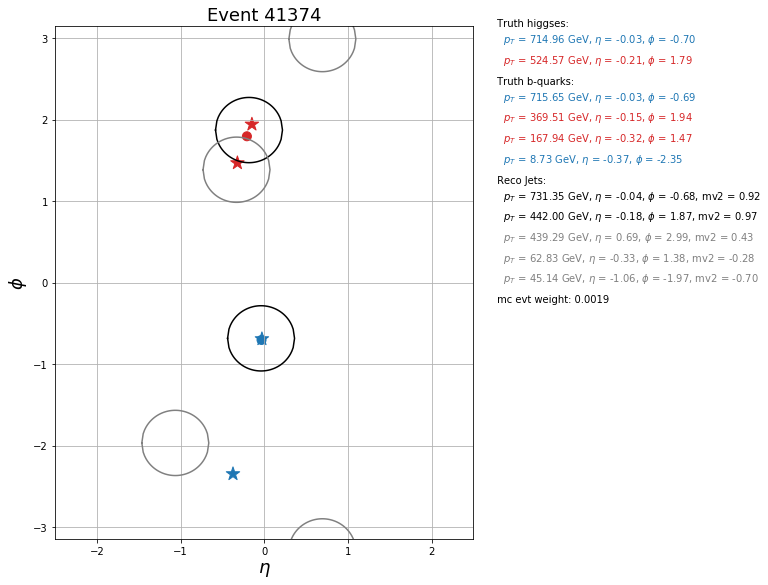

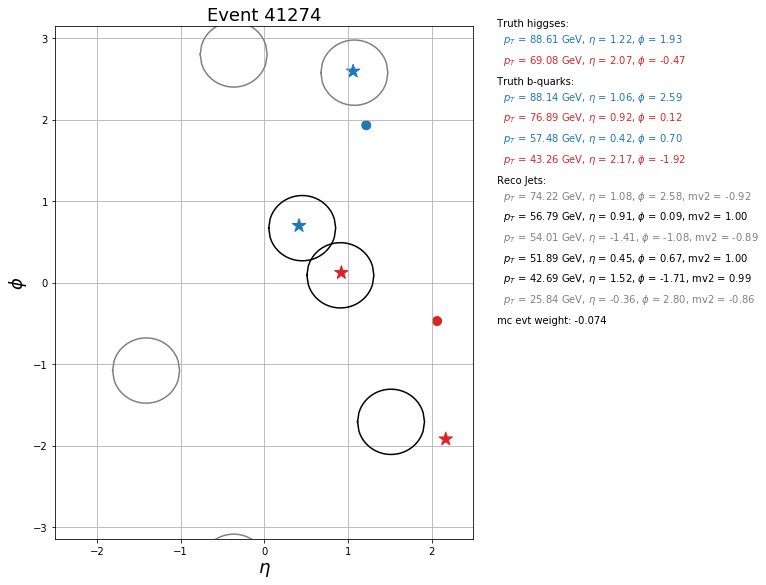

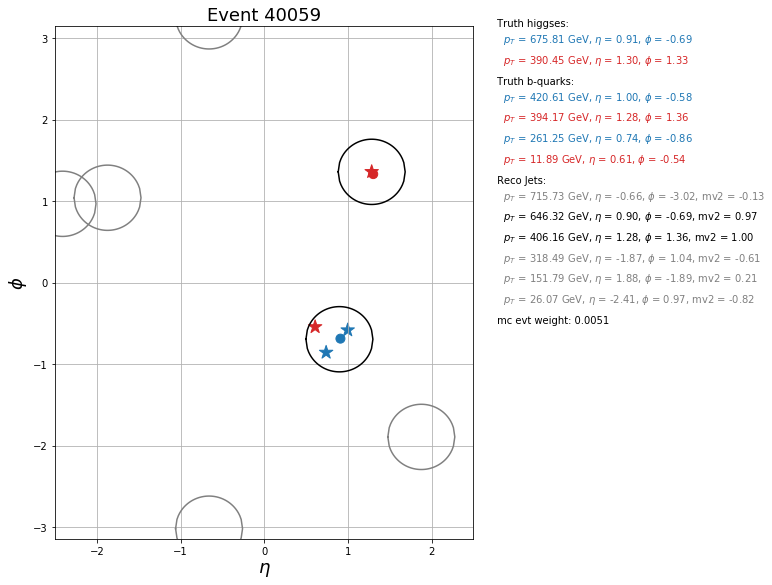

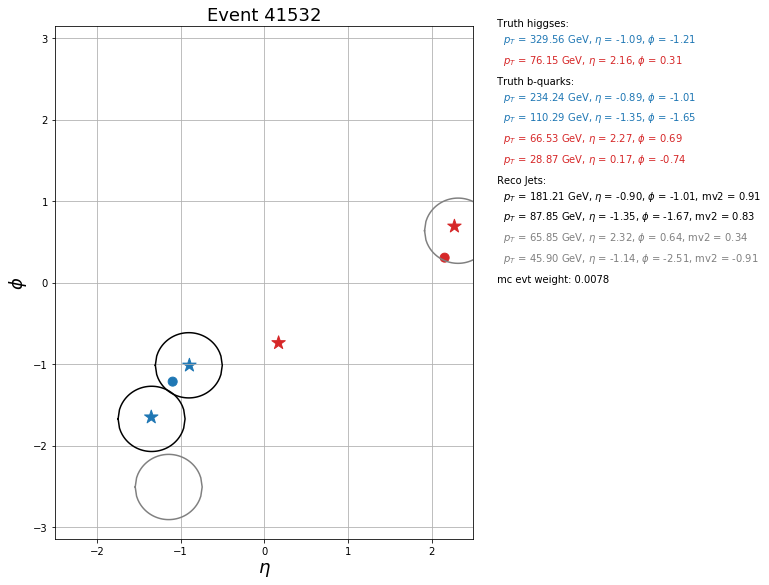

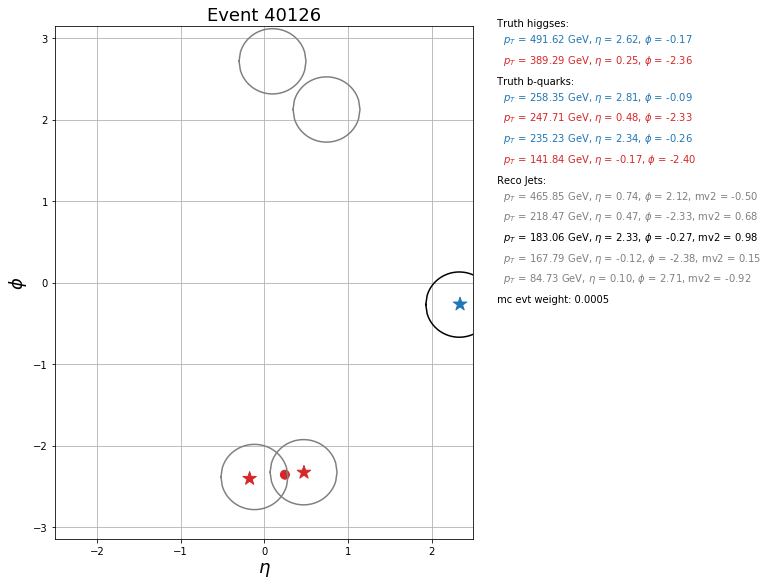

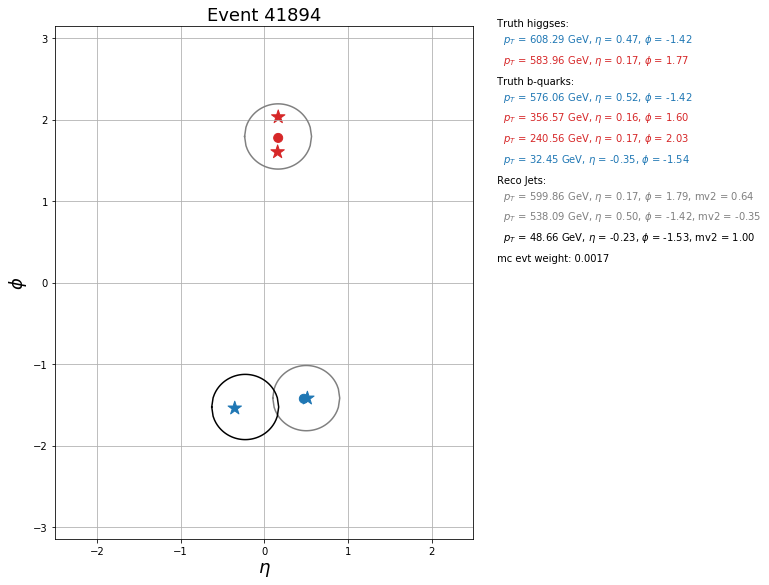

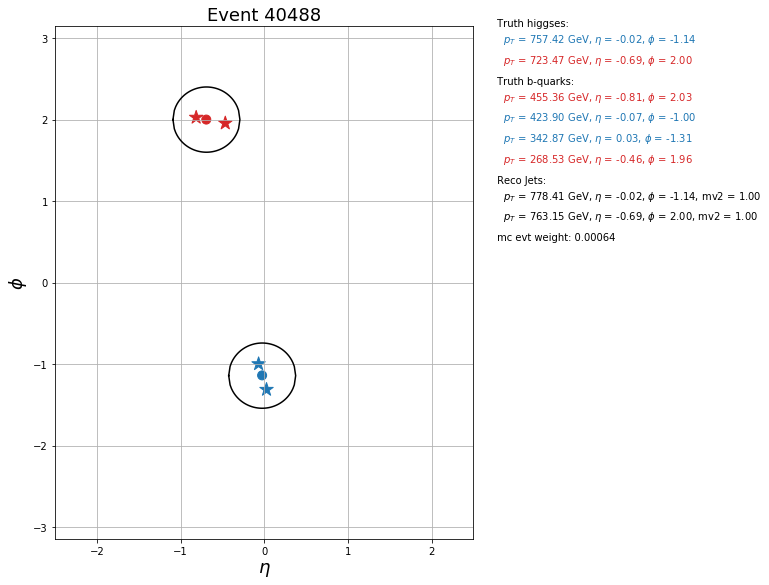

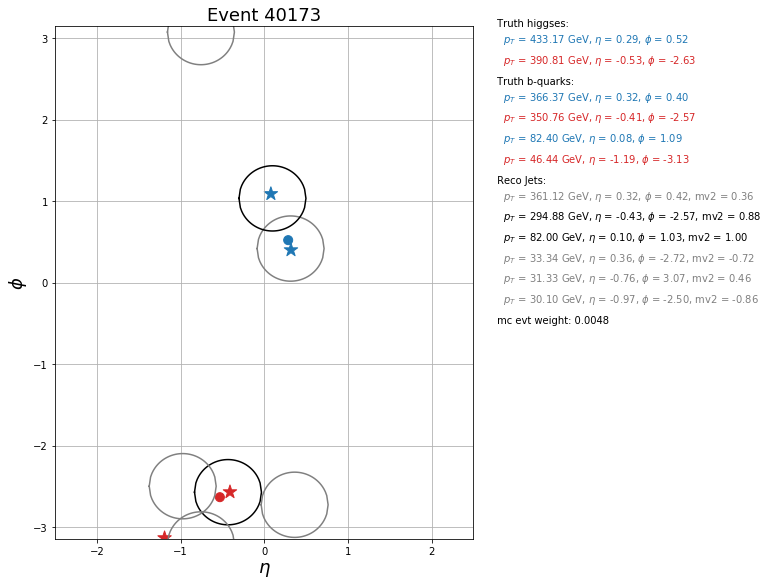

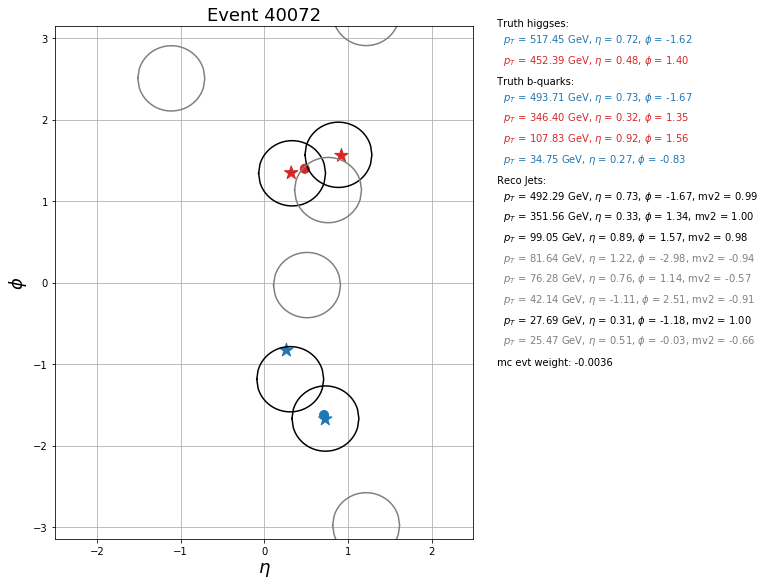

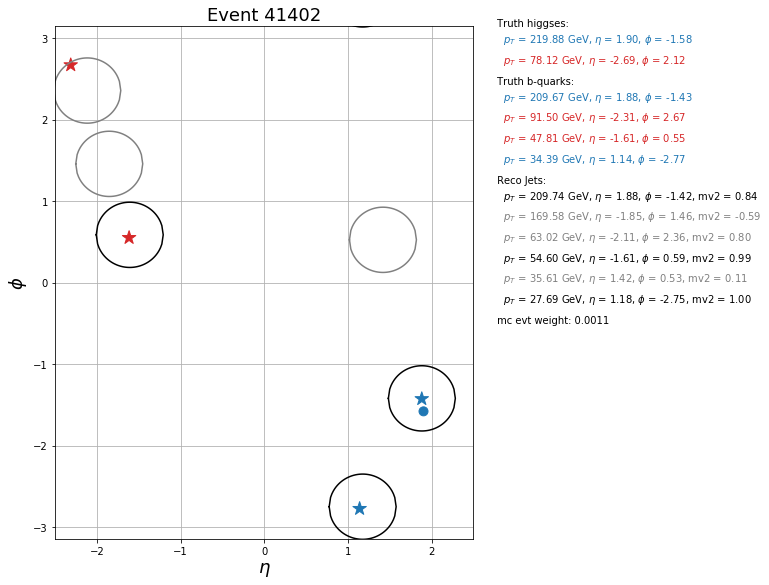

In [23]:
evtDisplayDir = figDir + '/evtDisplaysNotFourJets'

counter=0

for ievt in trigOnly[(~first_cut) & (~reco_match)].index:
    
    truthInfo(ievt,trigOnly,figDir=evtDisplayDir)
    counter += 1
    
    if counter == 25:
        break

**Conclusion:** Based on these event displays, I can ID four classes of objects:
1. Events where a b-quark $p_T$ is below 20 GeV (I know this isn't right, because there's a smearing, so by calculating this number, I'm assuming a symmetrized variation, which I'm *not* sure is ok)
2. Events where a $b$-quark $|\eta| > 2.5$ 
3. Events where the $b$-quarks merged into a single R=0.4 jet. 
4. Events where our $\Delta R < 0.3$ match was too restrictive

For the first three categories, I have to rely on truth level info since I don't have jets.


**$b$-quark $p_T$**

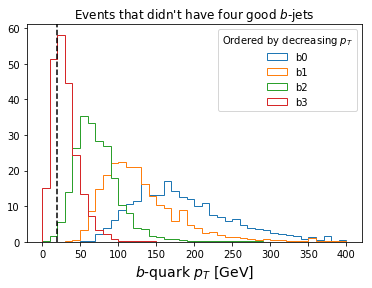

In [24]:
nBins=40
my_title = "Events that didn't have four good $b$-jets"
    
mask1 = (~first_cut) & (~reco_match)
    
for ib in range(4):

    key = 'b{}_pt'.format(ib)
    plt.hist(trigOnly.loc[mask1,key], bins=nBins, range=(0,400),
             histtype='step', label='b{}'.format(ib),
             weights=trigOnly.loc[mask1,'mcEventWeight'])

# Overlay a line at 20 GeV
ylim = plt.ylim()
plt.plot([20]*2,ylim,'k--')
plt.ylim(ylim)
    
plt.legend(title='Ordered by decreasing $p_T$')
plt.xlabel('$b$-quark $p_T$ [GeV]',fontsize=14)
plt.title(my_title)
plt.savefig('{}/notFourGoodJets/noRecoJetMatch_bi_pt.pdf'.format(figDir))
plt.show()

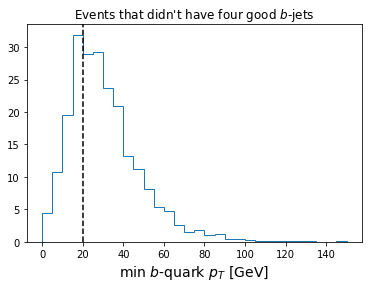

In [25]:
n, edg, _ = plt.hist(trigOnly.loc[mask1,'b3_pt'], bins=30, range=(0,150),
                     histtype='step', label='b{}'.format(ib),
                     weights=trigOnly.loc[mask1,'mcEventWeight'])

# Overlay a line at 20 GeV
ylim = plt.ylim()
plt.plot([20]*2,ylim,'k--')
plt.ylim(ylim)

plt.xlabel('min $b$-quark $p_T$ [GeV]',fontsize=14)
plt.title(my_title)
plt.savefig('{}/notFourGoodJets/noRecoJetMatch_b3_pt.pdf'.format(figDir))
plt.show()

Ok, so there's obviously some fuzz so I think it's probably important to report a curve with a range of efficiencies.

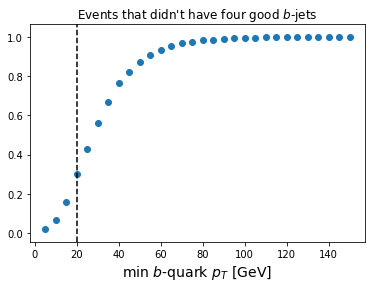

In [26]:
ptEff = np.add.accumulate(n) / np.sum(n) 

plt.scatter(edg[1:],ptEff)

# Overlay a line at 20 GeV
ylim = plt.ylim()
plt.plot([20]*2,ylim,'k--')
plt.ylim(ylim)

plt.xlabel('min $b$-quark $p_T$ [GeV]',fontsize=14)
plt.title(my_title)

plt.savefig('{}/notFourGoodJets/noRecoJetMatch_b3_pt_cdf.pdf'.format(figDir))
plt.show()

Ok, so using this estimate that we're losing $b$-quarks due to the the $p_T$, this is about a 30% effect, although it might be more like 50%.

In [27]:
printBins = 8
pteff_df = pd.DataFrame(ptEff[:printBins],index=['{:1.0f} GeV'.format(pt) for pt in edg[1:1+printBins]],
                        columns=['min $b$-quark $(p_T)$ below cutoff'])
print('Events failing four good b-jets cut without four truth match reco jets')
pteff_df.round(3)

Events failing four good b-jets cut without four truth match reco jets


min $b$-quark $(p_T)$ below cutoff
5 GeV                                0.020
10 GeV                               0.068
15 GeV                               0.156
20 GeV                               0.300
25 GeV                               0.430
30 GeV                               0.562
35 GeV                               0.669
40 GeV                               0.763

**$b$-quark $\eta$**

*Sanity check: What range should I be using?*

It's also important to have the correct ranges for my discriminant since values outside of the range are not included.

In [28]:
eta_min = np.min(trigOnly.loc[mask1,['b{}_eta'.format(ib,var) for ib in range(4)]].values)
eta_max = np.max(trigOnly.loc[mask1,['b{}_eta'.format(ib,var) for ib in range(4)]].values)

eta_min,eta_max

(-5.975807189941406, 6.515135765075684)

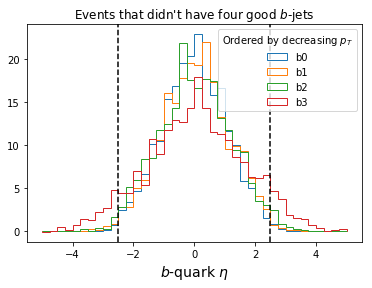

In [29]:
nBins=40

for ib in range(4):

    key = 'b{}_eta'.format(ib)
    plt.hist(trigOnly.loc[mask1,key], bins=nBins, range=(-5,5),
             histtype='step', label='b{}'.format(ib),
             weights=trigOnly.loc[mask1,'mcEventWeight'])

# Overlaya linse at |eta| =2.5 
ylim = plt.ylim()
for eta in [-2.5,2.5]:
    plt.plot([eta]*2,ylim,'k--')
plt.ylim(ylim)
    
plt.legend(title='Ordered by decreasing $p_T$',loc='upper right')
plt.xlabel('$b$-quark $\eta$',fontsize=14)
plt.title(my_title)
plt.savefig('{}/notFourGoodJets/noRecoJetMatch_bi_eta.pdf'.format(figDir))
plt.show()

Next, look at the max $|\eta|$ for the event, but given the plot above, clearly this is not going to be as large of an effect as $p_T$.

In [30]:
teta_max = np.max(np.abs(trigOnly.loc[mask1,['b{}_eta'.format(ib,var) for ib in range(4)]].values),axis=1)

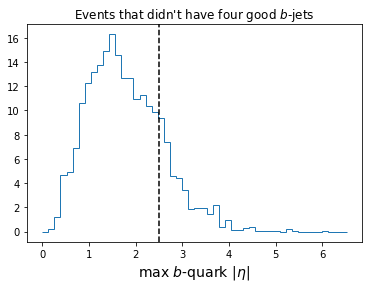

In [31]:
n, edg, _ = plt.hist(teta_max, bins=50, range=(0,np.max(teta_max)),
                     histtype='step', label='b{}'.format(ib),
                     weights=trigOnly.loc[mask1,'mcEventWeight'])

# Overlay a line at 20 GeV
ylim = plt.ylim()
plt.plot([2.5]*2,ylim,'k--')
plt.ylim(ylim)

plt.xlabel('max $b$-quark $| \eta |$',fontsize=14)
plt.title(my_title)

plt.savefig('{}/notFourGoodJets/noRecoJetMatch_max_abs_bi_eta.pdf'.format(figDir))

plt.show()

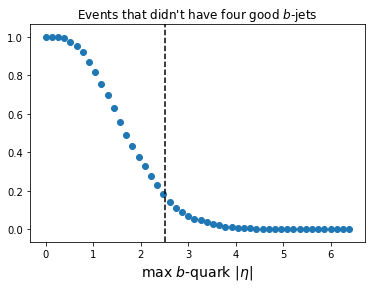

In [32]:
etaEff = np.add.accumulate(n[::-1])[::-1] / np.sum(n) 

plt.scatter(edg[:-1],etaEff)

ylim = plt.ylim()
plt.plot([2.5]*2,ylim,'k--')
plt.ylim(ylim)

plt.xlabel('max $b$-quark $| \eta |$',fontsize=14)
plt.title(my_title)

plt.savefig('{}/notFourGoodJets/noRecoJetMatch_max_abs_bi_eta_cdf.pdf'.format(figDir))

plt.show()

In [33]:
eta_cutoffs = [2,2.25,2.5,2.75,3]
den = np.sum(trigOnly.loc[mask1,'mc_sf'])
vals = [np.sum(trigOnly.loc[mask1,'mcEventWeight'][teta_max > etai]) / den for etai in eta_cutoffs]

etaeff_df = pd.DataFrame(vals,index=['{:1.2f}'.format(eta) for eta in eta_cutoffs],
                        columns=['max $b$-quark $\eta$ above cutoff'])
print('Events failing four good b-jets cut without four truth match reco jets')
etaeff_df.round(2)

Events failing four good b-jets cut without four truth match reco jets


max $b$-quark $\eta$ above cutoff
2.00                               0.37
2.25                               0.27
2.50                               0.18
2.75                               0.11
3.00                               0.07

Ok, so this is about a 20% effect, or half as important as the $p_T$ effect that I saw above.

**$b$s merging**

The allowed set of opening angles for decays from a resonance is

$$\Delta R \lesssim \frac{2m}{p_T}$$

So this means once one of the higgs $p_T$s is greater than 625 GeV, the $b$s will become boosted into a single $R=0.4$ jet.


In [34]:
2*125/0.4

625.0

In [35]:
2*125/0.8

312.5

In [36]:
# I just want an idea for where to put the limits
np.max(trigOnly.loc[mask1,['h{}_pt'.format(ih) for ih in range(2)]].values)

2850.444091796875

Woah!! We can have SM with higgs $p_T$s at 3 TeV??

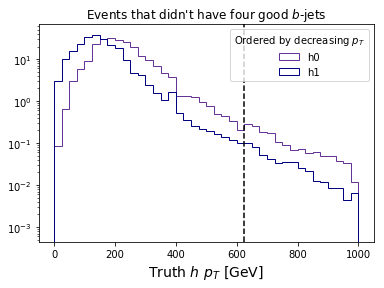

In [37]:
nBins=40
    
for ih, c in enumerate(['rebeccapurple','navy']):

    key = 'h{}_pt'.format(ih)
    plt.hist(trigOnly.loc[mask1,key], bins=nBins, range=(0,1000),
             histtype='step', label='h{}'.format(ih),color=c,
             weights=trigOnly.loc[mask1,'mcEventWeight'],log=True)

# Overlay a line at 20 GeV
ylim = plt.ylim()
plt.plot([625]*2,ylim,'k--')
plt.ylim(ylim)
    
plt.legend(title='Ordered by decreasing $p_T$',
           loc='upper right',facecolor='white')
plt.xlabel('Truth $h$ $p_T$ [GeV]',fontsize=14)
plt.title(my_title)
plt.savefig('{}/notFourGoodJets/noRecoJetMatch_hi_pt.pdf'.format(figDir))
plt.show()

Ok, so I needed to make this log scale, but the message here is that this seems not to be a dominant effect.

In [38]:
np.sum(trigOnly.loc[mask1,'mcEventWeight'][trigOnly.loc[mask1,'h0_pt'] > 625]) / den

0.00760236493692435

In [39]:
np.sum(trigOnly.loc[mask1,'mcEventWeight'][trigOnly.loc[mask1,'h0_pt'] > 312.5]) / den

0.13081100590895978

Although a more accurate (but more time consuming) way to look at this would be to look at the opening angles between the $b$-quarks, because lower $p_T$ higgses can have closer decay products as well.



**Relevant columns to calculate this:**
- b{i}_hidx: To determine which HC each of the bs matches to 
- b{i}_pt,eta,phi to reconstruct *vectors* to calculate the $\Delta R$

Or, I could just calculate $\Delta R$ myself, and probably this will be easier!


Ok, so this required a bit of numpy gymnastics, but I think the (vectorized) solutions is
1. Use b{i}_hidx to get the higgs indices for each of the bs
2. I can then *mask* each of the variables that I'm trying to use with this list. This returns a 1D array
3. Reshape the array to have shape (N,2)
4. Then I can manipulate these variables to calculate the quantities of interest.

In [40]:
b_hidx = trigOnly[['b{}_hidx'.format(ib) for ib in range(4)]].values
betas = trigOnly[['b{}_eta'.format(ib) for ib in range(4)]].values
bphis = trigOnly[['b{}_phi'.format(ib) for ib in range(4)]].values

In [41]:
for hi in range(2):
    
    etaKey = 'h{}_detas'.format(hi)
    phiKey = 'h{}_dphis'.format(hi)
    
    # Calculate the detas
    h_betas = np.reshape(betas[b_hidx==hi],(-1,2))
    trigOnly[etaKey] = h_betas[:,0] - h_betas[:,1]
    
    # Calculate the dphis
    h_bphis = np.reshape(bphis[b_hidx==hi],(-1,2))
    trigOnly[phiKey] = h_bphis[:,0] - h_bphis[:,1]
    
    # Check the 2pi wrap around
    highPhi = trigOnly[phiKey] > np.pi
    trigOnly.loc[highPhi,phiKey] = trigOnly.loc[highPhi,phiKey]-2*np.pi
    
    lowPhi = trigOnly[phiKey] < -np.pi
    trigOnly.loc[lowPhi,phiKey] = trigOnly.loc[lowPhi,phiKey]+2*np.pi
    
    # Use the dr formula
    trigOnly['h{}_drs'.format(hi)] = np.sqrt(np.power(trigOnly[etaKey],2) + np.power(trigOnly[phiKey],2))
    

Ok, let's just sanity check that we calculate these variables correctly!

All events that passed the trigger


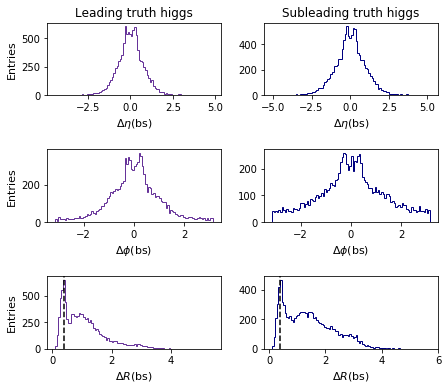

In [42]:
fig, axs = plt.subplots(3,2,figsize=(7,6))
fig.subplots_adjust(hspace=0.75,wspace=0.25)

for row,var,xlabel in zip(range(3),['detas','dphis','drs'],
                          ['$\Delta \eta$','$\Delta\phi$','$\Delta R$']):

    axs[row,0].set_ylabel('Entries',fontsize=11)
    
    for hi,c in enumerate(['rebeccapurple','navy']):
    
        key = "h{}_{}".format(hi,var)
        axs[row,hi].hist(trigOnly.loc[mask1,key],100, 
                         histtype='step',color=c)
        axs[row,hi].set_xlabel('{}(bs)'.format(xlabel),fontsize=11)
    
        # I think it would also be interesting to overlay where R = 0.4 is
        if var=='drs':
            ylim = axs[row,hi].get_ylim()
            axs[row,hi].plot([0.4]*2,ylim,'k--')
            axs[row,hi].set_ylim(ylim)
            
axs[0,0].set_title('Leading truth higgs')
axs[0,1].set_title('Subleading truth higgs')

plt.savefig('{}/truth/hi_deta_dphi_dr.pdf'.format(figDir))

print('All events that passed the trigger')
plt.show()


For all events that are passing the trigger, this looks like a 5-10% effect. It's going to be interesting to see how this number evolves for all the events that are passing the trigger and also don't have the correct four b-jets reconstructed.

Let's go ahead and calculate it!

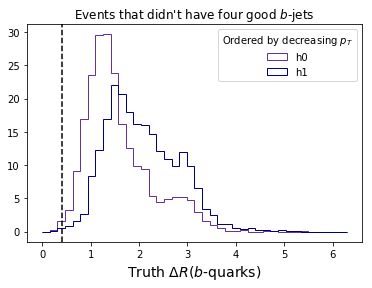

In [43]:
nBins=40
    
for ih, c in enumerate(['rebeccapurple','navy']):

    key = 'h{}_drs'.format(ih)
    plt.hist(trigOnly.loc[mask1,key], bins=nBins, range=(0,2*np.pi),
             histtype='step', label='h{}'.format(ih),color=c,
             weights=trigOnly.loc[mask1,'mcEventWeight'])

ylim = plt.ylim()
plt.plot([0.4]*2,ylim,'k--')
plt.ylim(ylim)
    
plt.legend(title='Ordered by decreasing $p_T$',
           loc='upper right',facecolor='white')
plt.xlabel('Truth $\Delta R$($b$-quarks)',fontsize=14)
plt.title(my_title)
plt.savefig('{}/notFourGoodJets/noRecoJetMatch_hi_drs.pdf'.format(figDir))
plt.show()

In [44]:
h_dr_min = np.min(trigOnly.loc[mask1,['h{}_drs'.format(ih) for ih in range(2)]].values,axis=1)

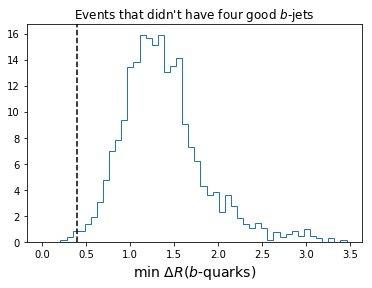

In [45]:
n, edg, _ = plt.hist(h_dr_min, bins=50, range=(0,np.max(h_dr_min)),
                     histtype='step', label='b{}'.format(ib),
                     weights=trigOnly.loc[mask1,'mcEventWeight'])

ylim = plt.ylim()
plt.plot([0.4]*2,ylim,'k--')
plt.ylim(ylim)

plt.xlabel('min $\Delta R$($b$-quarks)',fontsize=14)
plt.title(my_title)

plt.savefig('{}/notFourGoodJets/noRecoJetMatch_min_hi_drs.pdf'.format(figDir))

plt.show()

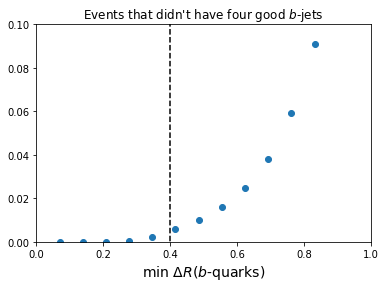

In [46]:
drEff = np.add.accumulate(n) / np.sum(n) 

plt.scatter(edg[1:],drEff)

ylim = plt.ylim()
plt.plot([0.4]*2,ylim,'k--')

# Zoom in so there's something to see!
plt.xlim(0,1)
plt.ylim(0,0.1)

plt.xlabel('min $\Delta R$($b$-quarks)',fontsize=14)
plt.title(my_title)

plt.savefig('{}/notFourGoodJets/noRecoJetMatch_min_hi_drs_cdf.pdf'.format(figDir))

plt.show()

Ok, yep, this is *still* a < 1% effect.

Just for fun... Let's plot the opening angle between the $b$s versus the $p_T$ of the higgses.

In [47]:
pts = np.linspace(1,1000)
drs = 2 * 125 / pts

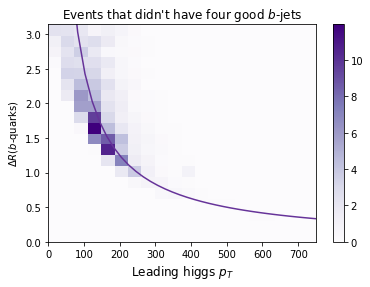

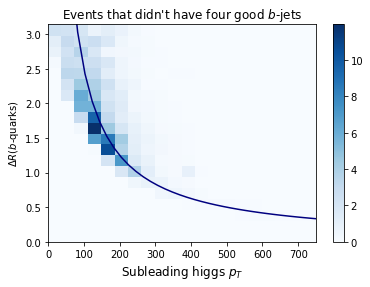

In [48]:
for hi, cmap, htag,c in zip(range(2),['Purples','Blues'],
                            ['Leading','Subleading'],['rebeccapurple','navy']):

    plt.figure()
    plt.hist2d(trigOnly.loc[mask1,'h{}_pt'.format(ih)],
               trigOnly.loc[mask1,'h{}_drs'.format(ih)],
               20,[[0,750],[0,np.pi]],
               cmap=cmap,#norm=LogNorm(),
               weights=trigOnly.loc[mask1,'mcEventWeight'])
    plt.colorbar()

    plt.plot(pts,drs,c)

    plt.xlabel(htag+' higgs $p_T$',fontsize=12)
    plt.ylabel('$\Delta R$($b$-quarks)')
    plt.title(my_title)

    plt.savefig('{}/notFourGoodJets/noRecoJetMatch_dRjj_vs_d{}_pt.pdf'.format(figDir,hi))

plt.show()

**Summary:**  What have we learned and where are we now?

Since there's some resolution effects between the $b$-quark and the jet $p_T$, it's hard for me to tell whether these numbers add up or not.

Maybe I'll check how my analysis proceeds through the next selection cuts?

*I could also check the validity of this $\Delta R$ truth definition by looking at the $\Delta R$ to the closest jet for the non truth matched $b$-quark, and seeing how often the closest jet is a $b$ vs $c$ and $l$, and how likely I was to reconstruct it or not?* 

Also Michael was mentioning, could be a failure of the jet clustering alg - but I'm not sure how to probe this...


**$\Delta R$ match failure**

**Venn diagram**

Maybe I want to double check some of these numbers before figuring out how to aggregate these classes together?


## Category 2: Events failing our four good b-jets cut, WITH four $p_T$ > 20 GeV, $|\eta|$ < 2.5 calo jets $\Delta R$ matched to $b$-quarks

**Look at the $p_T$ and $\eta$ for the $b$-quarks for the jets failing the four b-jets cut**

In [49]:
figDir

'../figures/SMNR_16/2016_triggers'

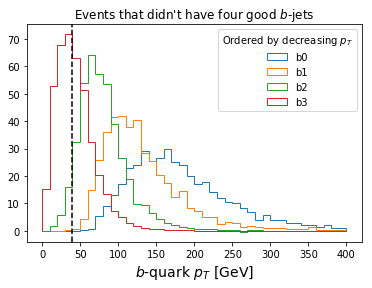

In [50]:
nBins=40
my_title = "Events that didn't have four good $b$-jets"
    
for ib in range(4):

    key = 'b{}_pt'.format(ib,var)
    plt.hist(trigOnly.loc[~first_cut,key], bins=nBins, range=(0,400),
             histtype='step', label='b{}'.format(ib),
             weights=trigOnly.loc[~first_cut,'mcEventWeight'])

# Overlay a line at 40 GeV
ylim = plt.ylim()
plt.plot([40]*2,ylim,'k--')
plt.ylim(ylim)
    
plt.legend(title='Ordered by decreasing $p_T$')
plt.xlabel('$b$-quark $p_T$ [GeV]',fontsize=14)
plt.title(my_title)
#plt.savefig('{}/notFourGoodJets_bi_pt.pdf'.format(figDir))
plt.show()

In [51]:
num = np.sum(trigOnly.loc[(~first_cut) & (trigOnly.b3_pt < 40),'mc_sf'])
den = np.sum(trigOnly.loc[(~first_cut),'mc_sf'])

tpt_loss = num / den

print('For {}% of the events that failed four good b-jets, b3 pT < 40 GeV'.format(tpt_loss*100))

For 50.03774202518926% of the events that failed four good b-jets, b3 pT < 40 GeV


Ok, so we lose most of these events becuase of a low $p_T$ $b$-quark.

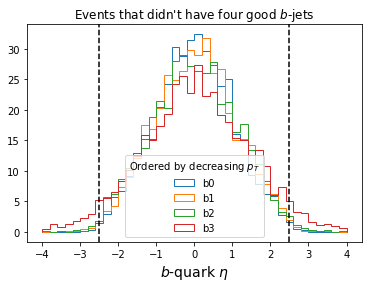

In [52]:
for ib in range(4):

    key = 'b{}_eta'.format(ib,var)
    plt.hist(trigOnly.loc[~first_cut,key], bins=nBins, range=(-4,4),
             histtype='step', label='b{}'.format(ib),
             weights=trigOnly.loc[~first_cut,'mcEventWeight'])

# Overlay a lines at |eta| = 2.5
ylim = plt.ylim()
plt.plot([-2.5]*2,ylim,'k--')
plt.plot([2.5]*2,ylim,'k--')
plt.ylim(ylim)
    
plt.legend(title='Ordered by decreasing $p_T$')
plt.xlabel('$b$-quark $\eta$',fontsize=14)
plt.title(my_title)
#plt.savefig('{}/notFourGoodJets_bi_eta.pdf'.format(figDir))
plt.show()

In [53]:
max_eta = np.max(np.abs(trigOnly[['b{}_eta'.format(i) for i in range(4)]].values),axis=1)

In [54]:
num = np.sum(trigOnly.loc[(~first_cut) & (max_eta > 2.5),'mc_sf'])
teta_loss = num / den

print('For {}% of the events that failed four good b-jets, max(b eta) > 2.5'.format(teta_loss*100))

For 9.700925778597902% of the events that failed four good b-jets, max(b eta) > 2.5


Then we also have that it $b$-tagging is about 80% effient for jets in the $p_T$ range of our signal.

*Note: We're acutally using the 70% WP, but I think that the $p_T$ for our signal tends to be higher than the inclusive $p_T$ range for $t\bar{t}$, so that's why I this estimate is conservative.*

In [55]:
print('Rough estimate for 4 b-tags: {}'.format(.7**4))

Rough estimate for 4 b-tags: 0.24009999999999995


There's some overlap between these numbers (obviously), but I think the conclusion here is that *it's not unreasonable that the initial 4 b-jet selection is throwing out 90% of our signal events.*

Now that we have a sample of reco jets matched to $b$-quarks, we can probe their properites to understand how we might want to 
- adjust $p_T$ thresholds
- use different $b$-tagging WPs 

to improve our acceptance!

### Reco jet $p_T$s

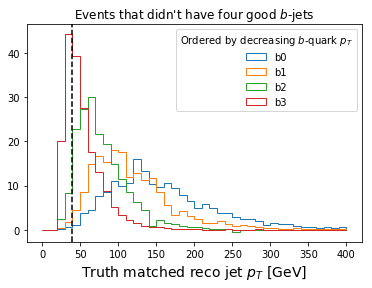

In [56]:
nBins=40
my_title = "Events that didn't have four good $b$-jets"

my_pts = []

mask = (~first_cut) & reco_match

for ib in range(4):

    cols = ['b{}_jidx'.format(ib),'resolvedJets_pt']
    var = np.array([pts[ji] for _, (ji,pts) in trigOnly.loc[mask,cols].iterrows()])
    my_pts.append(var)
    
    plt.hist(var, bins=nBins, range=(0,400),
             histtype='step', label='b{}'.format(ib),
             weights=trigOnly.loc[mask,'mcEventWeight'])

# Overlay a line at 40 GeV
ylim = plt.ylim()
plt.plot([40]*2,ylim,'k--')
plt.ylim(ylim)
    
plt.legend(title='Ordered by decreasing $b$-quark $p_T$')
plt.xlabel('Truth matched reco jet $p_T$ [GeV]',fontsize=14)
plt.title(my_title)
plt.savefig('{}/notFourGoodJets_ji_pt.pdf'.format(figDir))
plt.show()

How often is *one* of these truth matched jets less than 40 GeV?

In [57]:
min_reco_pts = np.min(np.vstack(my_pts),axis=0)

num = np.sum(trigOnly.loc[mask,'mc_sf'][min_reco_pts < 40])
den = np.sum(trigOnly.loc[mask,'mc_sf'])

print('For {}% of the events with reco matches failing 4 b-jets had a jet with pT < 40 GeV'.format(num / den *100))

For 36.97769384636762% of the events with reco matches failing 4 b-jets had a jet with pT < 40 GeV


### Reco jet $\eta$s

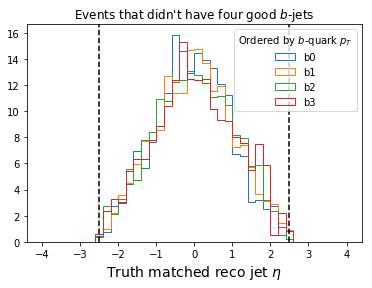

In [58]:
my_etas = []

for ib in range(4):

    cols = ['b{}_jidx'.format(ib),'resolvedJets_eta']
    var = np.array([jetas[ji] for _, (ji,jetas) in trigOnly.loc[mask,cols].iterrows()])
    my_etas.append(var)
    
    plt.hist(var, bins=nBins, range=(-4,4),
             histtype='step', label='b{}'.format(ib),
             weights=trigOnly.loc[mask,'mcEventWeight'])

# Overlay a lines at |eta| = 2.5
ylim = plt.ylim()
plt.plot([-2.5]*2,ylim,'k--')
plt.plot([2.5]*2,ylim,'k--')
plt.ylim(ylim)
    
plt.legend(title='Ordered by $b$-quark $p_T$',loc='upper right')
plt.xlabel('Truth matched reco jet $\eta$',fontsize=14)
plt.title(my_title)
plt.savefig('{}/notFourGoodJets_ji_eta.pdf'.format(figDir))
plt.show()

In [59]:
max_abs_etas = np.min(np.abs(np.vstack(my_etas)),axis=0)

num = np.sum(trigOnly.loc[mask,'mc_sf'][max_abs_etas > 2.5])
den = np.sum(trigOnly.loc[mask,'mc_sf'])

reco_eta_loss = num / den

print('For {}% of the events with reco matches failing 4 b-jets had a jet with |eta| > 2.5'.format(reco_eta_loss *100))

For 0.0% of the events with reco matches failing 4 b-jets had a jet with |eta| > 2.5


Lol, this was actually a *super* stupid check, because I the reco jets saved by XhhCommon are required to have $|\eta|$ < 2.5

### Reco jet MV2s

In [60]:
for c in trigOnly.columns:
    if 'resolved' in c:
        print(c)

nresolvedJets
resolvedJets_E
resolvedJets_pt
resolvedJets_phi
resolvedJets_eta
resolvedJets_MV2c10
resolvedJets_HadronConeExclTruthLabelID
resolvedJets_is_MV2c10_FixedCutBEff_70
resolvedJets_SF_MV2c10_FixedCutBEff_70


In [61]:
Db_cuts = {
    'MV2c10'    : {60 : 0.94,
                   70 : 0.83,
                   77 : 0.64,
                   85 : 0.11},
    'MV2c10mu'  : {60 : 0.95,
                   70 : 0.87,
                   77 : 0.71,
                   85 : 0.23},
    'MV2c10rnn' : {60 : 0.96,
                   70 : 0.87,
                   77 : 0.71,
                   85 : 0.26},
    
    'DL1'   : {60 : 2.74,
               70 : 2.02,
               77 : 1.45,
               85 : 0.46},
    'DL1mu' : {60 : 2.72,
               70 : 1.83,
               77 : 1.10,
               85 : 0.12},
    'DL1rnn': {60 : 4.31,
               70 : 2.98,
               77 : 2.23,
               85 : 1.32}
}


In [62]:
for k,v in Db_cuts['MV2c10'].items():
    print(k,v)

60 0.94
70 0.83
77 0.64
85 0.11


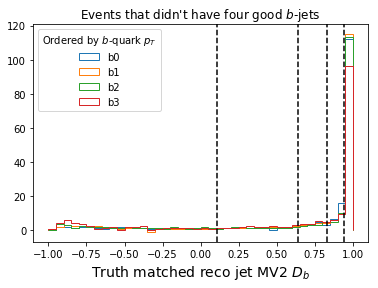

In [63]:
my_mv2s = []
my_btags = []

for ib in range(4):

    jidx = 'b{}_jidx'.format(ib)
    
    var = np.array([mv2s[ji] for _, (ji,mv2s) in trigOnly.loc[mask,[jidx,'resolvedJets_MV2c10']].iterrows()])
    my_mv2s.append(var)
    
    tagged = np.array([btags[ji] for _, (ji,btags) in trigOnly.loc[mask,[jidx,'resolvedJets_is_MV2c10_FixedCutBEff_70']].iterrows()])
    my_btags.append(tagged)
    
    plt.hist(var, bins=nBins, range=(-1,1),
             histtype='step', label='b{}'.format(ib),
             weights=trigOnly.loc[mask,'mcEventWeight'])

# Overlay the discriminant lines
ylim = plt.ylim()
for WP, Db in Db_cuts['MV2c10'].items():
    plt.plot([Db]*2,ylim,'k--')
plt.ylim(ylim)
    
plt.legend(title='Ordered by $b$-quark $p_T$',loc='upper left')
plt.xlabel('Truth matched reco jet MV2 $D_b$',fontsize=14)
plt.title(my_title)
plt.savefig('{}/notFourGoodJets_ji_mv2.pdf'.format(figDir))
plt.show()

Sanity check: To see how these four curves play into each other, let's look at the min mv2 of the truth matched $b$-jets.

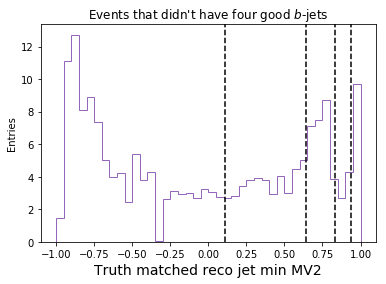

In [64]:
min_truthMatched_mv2 = np.min(np.vstack(my_mv2s), axis=0)

plt.hist(min_truthMatched_mv2, bins=nBins, range=(-1,1),
         color='C4',histtype='step',
         weights=trigOnly.loc[mask,'mcEventWeight'])

# Overlay the discriminant lines
ylim = plt.ylim()
for WP, Db in Db_cuts['MV2c10'].items():
    plt.plot([Db]*2,ylim,'k--')
plt.ylim(ylim)
    
plt.xlabel('Truth matched reco jet min MV2',fontsize=14)
plt.ylabel('Entries')
plt.title(my_title)
plt.savefig('{}/notFourGoodJets_ji_min_mv2.pdf'.format(figDir))

plt.show()

**Question:** What does the $p_T$ distribution look like for this jet that failed the MV2 cut?

In [65]:
argmin_truthMatched_mv2 = np.argmin(np.vstack(my_mv2s), axis=0)

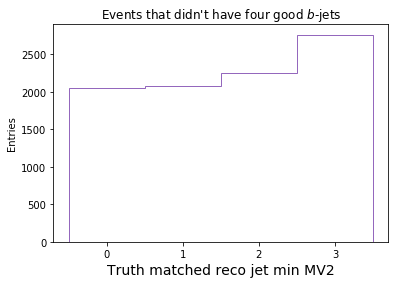

In [66]:
fig,ax = plt.subplots()

plt.hist(argmin_truthMatched_mv2-0.5,4,(-0.5,3.5),color='C4',histtype='step')

plt.xlabel('Truth matched reco jet min MV2',fontsize=14)
plt.ylabel('Entries')
plt.title(my_title)

xticks = range(0,4)
ax.set_xticks(xticks)
ax.set_xticklabels(["{:d}".format(xi) for xi in xticks])

plt.savefig('{}/notFourGoodJets_argmin_ji_min_mv2.pdf'.format(figDir))

plt.show()

**Lesson:** The trailing $b$-jet $p_T$ is the most likely to have the minimum MV2 score, but this isn't always the case.

In [67]:
evt_pts = np.vstack(my_pts)

In [68]:
pt_min_truthMatched_mv2 = np.array([evt_pts[ijet,ievt] for ievt, ijet in enumerate(argmin_truthMatched_mv2)])

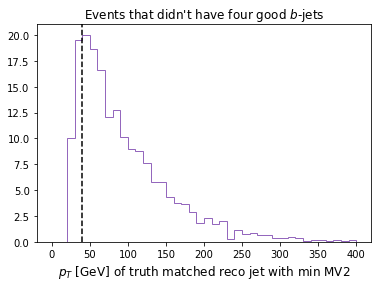

In [69]:
plt.hist(pt_min_truthMatched_mv2, bins=nBins, range=(0,400),
         color='C4', histtype='step', 
         weights=trigOnly.loc[mask,'mcEventWeight'])

# Overlay a line at 40 GeV
ylim = plt.ylim()
plt.plot([40]*2,ylim,'k--')
plt.ylim(ylim)
    
plt.xlabel('$p_T$ [GeV] of truth matched reco jet with min MV2',fontsize=12)
plt.title(my_title)
plt.savefig('{}/notFourGoodJets_pt_ji_min_mv2.pdf'.format(figDir))
plt.show()

In [70]:
btags = np.sum(np.vstack(my_btags),axis=0)

num = np.sum(trigOnly.loc[mask,'mc_sf'][btags < 4])

btag_loss = num / den

print('For {}% of the events with reco matches didn\'t have 4 b-tags'.format(btag_loss *100))

For 91.76283803656553% of the events with reco matches didn't have 4 b-tags


Let's do another sanity check to make sure the values from the CDI are correct as well.

In [71]:
mv2_btags = np.sum(np.vstack(my_mv2s) > Db_cuts['MV2c10'][70], axis=0)

num = np.sum(trigOnly.loc[mask,'mc_sf'][mv2_btags < 4])

btag_loss = num / den

print('For {}% of the events with reco matches didn\'t have 4 b-tags'.format(btag_loss *100))

For 91.78805951495609% of the events with reco matches didn't have 4 b-tags


Ok, so up to two sig figs, this result is reasonable.

Ok, so $b$-tagging seems to be the main culprit, which I guess makes sense because we know b-tagging is worse at low $p_T$.

We can improve on this using:
1. Pseudo-continuous b-tagging
2. The 3b analysis category

We know it's harder to do $b$-tagging at low $p_T$ because
1. The tracks from the $b$-hadron decay are lower $p_T$ and harder to reconstruct due to multiple scattering effects
2. There are also more backgrounds at low $p_T$

**Plan:** To look at the interplay between the $b$-jet $p_T$ and the mv2 score, let's make some 2d scatter plots!

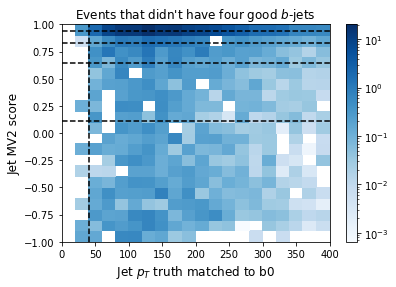

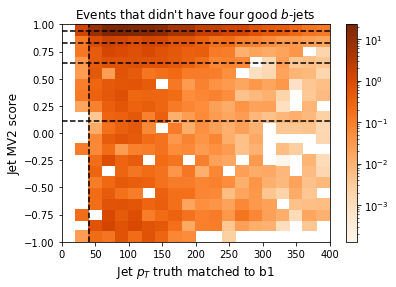

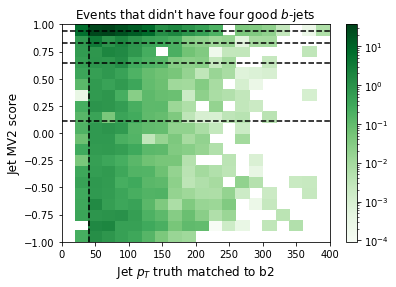

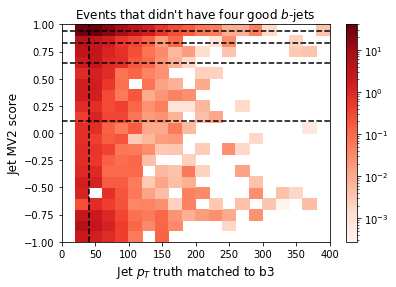

In [72]:
for ib,cmap in enumerate(['Blues','Oranges','Greens','Reds']):

    jidx = 'b{}_jidx'.format(ib)
    
    pts  = np.array([pts[ji] for _, (ji,pts) in trigOnly.loc[mask,[jidx,'resolvedJets_pt']].iterrows()])
    mv2s = np.array([mv2s[ji] for _, (ji,mv2s) in trigOnly.loc[mask,[jidx,'resolvedJets_MV2c10']].iterrows()])
    
    plt.figure()
    plt.hist2d(pts,mv2s, bins=20, range=[[0,400],[-1,1]],
               cmap=cmap,norm=LogNorm(),
               weights=trigOnly.loc[mask,'mcEventWeight'])
    
    plt.colorbar()
    
    # Overlay a line at 40 GeV
    ylim = plt.ylim()
    plt.plot([40]*2,ylim,'k--')
    plt.ylim(ylim)
    
    # Overlay the discriminant lines
    xlim = plt.xlim()
    for WP, Db in Db_cuts['MV2c10'].items():
        plt.plot(xlim,[Db]*2,'k--')
    plt.xlim(xlim)
    
    
    plt.xlabel('Jet $p_T$ truth matched to b{}'.format(ib),fontsize=12)
    plt.ylabel('Jet MV2 score',fontsize=12)
    plt.title(my_title)
    plt.show()

Maybe make some kind of a scatter plot of mv2 vs jet $p_T$ for the jet in the event with the minimim mv2 score?

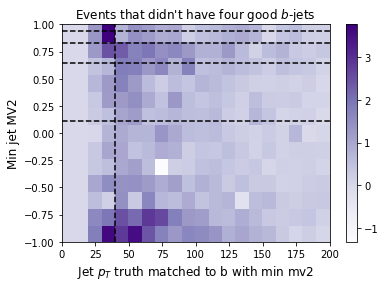

In [73]:
plt.figure()
plt.hist2d(pt_min_truthMatched_mv2,min_truthMatched_mv2, bins=[20,13], range=[[0,200],[-1,1]],
           cmap='Purples',#norm=LogNorm(),
           weights=trigOnly.loc[mask,'mcEventWeight'])

plt.colorbar()

# Overlay a line at 40 GeV
ylim = plt.ylim()
plt.plot([40]*2,ylim,'k--')
plt.ylim(ylim)

# Overlay the discriminant lines
xlim = plt.xlim()
for WP, Db in Db_cuts['MV2c10'].items():
    plt.plot(xlim,[Db]*2,'k--')
plt.xlim(xlim)


plt.xlabel('Jet $p_T$ truth matched to b with min mv2'.format(ib),fontsize=12)
plt.ylabel('Min jet MV2',fontsize=12)
plt.title(my_title)
plt.show()

Ok, I think this shows about how much we can gain by loosening the mv2 score, and it shows that we can gain quite a lot by loosening the mv2 cut on even *one* of the $b$-quarks, but even after lowering this, we can gain a bit more by lowering the jet $p_T$ too!

Also, the spikes at 0 show how much we would gain by *completely* loosening the jet $p_T$.


### Case for pseudo-continuous $b$-tagging

Ok, so I think that this is the place where I should calculate the signal efficiency for pseudo-continuous $b$-tagging!

So, even though there are five *b-tagging* bins and four jets, there aren't really that many options because we can't play with the first two jets, because we need two $b$-jets for our most efficient trigger, the XhhCommon filters on events with at least 2 $b$-tags, and the other anlayses all have 2b SRs.

Also, when other analyses are vetoing 3b events, they are using the 70% WP, so we probably won't be able to loosen the $3^{rd}$ $b$-jet lower than that, although if we want to iterate on this point, we could, but we will need to show that this category really helps us before digging into this.


So, I think I should start off with just loosening the mv2 of the $4^{th}$ jet, and seeing how much that helps us.  So I'll be looking at the efficacy of a tradeoff between a 3b and 4b category.




In [74]:
'''
Goal: Find the # of events in the 4+3 category
'''

mv2_cuts = [-1] + [Db_cuts['MV2c10'][wp] for wp in [60,70,77]]

for k,v in Db_cuts['MV2c10'].items():
    print(k,v)

60 0.94
70 0.83
77 0.64
85 0.11


In [75]:
# 3b + 1b @ 77% WP
for wp in [77,85]:
    mv2_btags_wp = np.sum(np.vstack(my_mv2s) > Db_cuts['MV2c10'][wp], axis=0)

    num = np.sum(trigOnly.loc[mask,'mc_sf'][(btags == 3) & (mv2_btags_wp == 4)])

    btag_gain_wp = num / den

    print('For {:.2f}% of the events with reco matches 3 b-tags + a b-tag @ {}% WP'.format(btag_gain_wp * 100,wp))

For 12.69% of the events with reco matches 3 b-tags + a b-tag @ 77% WP
For 27.24% of the events with reco matches 3 b-tags + a b-tag @ 85% WP


In [76]:
num = np.sum(trigOnly.loc[mask,'mc_sf'][(btags == 3)])
threeb_gain = num / den

print('For {:.2f}% of the events with reco matches 3 b-tags'.format(threeb_gain * 100,wp))

For 56.07% of the events with reco matches 3 b-tags


Ok, so we gain a little more by thinking about a 3b category than by thinking about loosening $p_T$ thresholds, which is good to know, but hardly the end of the story!

## Category 3

We *passed* the four goood jets selection, but failed to have the correct four jets.

I guess there are also a couple of cases here:

1. The correct four jets didn't exist

    I think this case is a lot less likely that cateogory 1, because once we have 4 high $p_T$ $b$-tags, we're probably not as likely to have the wrong ones, but we'll see!!

2. The correct four jets existed, but we failed to select them. This could be due to
    - The correct jet failed the $p_T$, $\eta$, or b-tag selection
    - There were more than 4 $b$-tags in the event, and the selection of the four leading in mv2 discriminant fucked us up.

In [77]:
# Checking if I had the correct four jets existed given I passed this cut


num = np.sum(trigOnly.loc[first_cut & (~reco_match),'mc_sf'])
den = np.sum(trigOnly.loc[first_cut,'mc_sf'])
noRecoJet = num / den

print('For {:.2f}% of the events that passed four good b-jets that didn\'t match to a reco jet'.format(noRecoJet*100))

For 11.46% of the events that passed four good b-jets that didn't match to a reco jet


In [78]:
print('P(4b_H | 4-tag)')

SyntaxError: invalid syntax (<ipython-input-78-38f129f1b1af>, line 1)

Yes, this # was really just a sanity check, b/c it's 1 - eff given by the first point on the green curve of my good jet selection evolving through the analysis curve.

**I can also calculate P(4 b | 4-tag) by selecting the 4 $b$s using the `resolvedJets_HadronConeExclTruthLabelID` branch**

In [ ]:
nBJets_hadF = np.array([np.sum(pdg == 5) for pdg in trigOnly.resolvedJets_HadronConeExclTruthLabelID])

In [ ]:
xrange = (-0.5,nBJets_hadF.max()+0.5)
nBins = int(xrange[1]-xrange[0])

labels = [x + ' 4 good $b$-jets cut' for x in ['failing','passing']]

for log, logTag in zip([False, True],['','_log']):

    plt.figure()
    plt.hist([nBJets_hadF[~first_cut],nBJets_hadF[first_cut]], 
             nBins, xrange, color = ['C0','C4',], 
             label=labels, stacked=True, log=log,
             weights=[trigOnly.loc[~first_cut,'mc_sf'],trigOnly.loc[first_cut,'mc_sf']])

    ylim = plt.ylim()
    plt.plot([3.5]*2,ylim,'k--')
    plt.ylim(ylim)

    plt.legend(loc='upper left')
    plt.xlabel('# of *true* $b$-jets from HadronConeExclTruthLabelID')
    plt.ylabel('Entries')
    
    plt.savefig('{}/fourGoodJets_HadronConeExclTruthLabelID{}.pdf'.format(figDir,logTag))
    
plt.show()

In [ ]:
num = np.sum(trigOnly.loc[first_cut & (nBJets_hadF >= 4),'mc_sf'])
print("P(4b | 4-tag) = {}".format(num / den))

### What are the properties of this suprious jet that we accidentally selected??

- Was it actually a $b$-jet?
- What was its $p_T$ / $\eta$?


# Category 4

We *passed* the four jet selection, and we had the corret 4 jets.

- How often were there extra $b$-tags / extra jets with $p_T$?


# In conclusion

So... this was the table that Rafael wanted me to make:


- Fraction of events with 4 b-Hadron matched jets (jb), and pt(jb, 1~4) > 40 GeV, and  |eta(jb, 1~4)| < 2.5 GeV AND exactly 4 70WP
- Fraction of events with 4 b-Hadron matched jets (jb), and pt(jb, 1~4) > 40 GeV, and  |eta(jb, 1~4)| < 2.5 GeV AND exactly 3 70WP
- Fraction of events with 4 b-Hadron matched jets (jb), and pt(jb, 1~4) > 40 GeV, and  |eta(jb, 1~4)| < 2.5 GeV AND exactly 3 70WP + 1 85WP
- Fraction of events with 4 b-Hadron matched jets (jb), and pt(jb, 1~4) > 40 GeV, and  |eta(jb, 1~4)| < 2.5 GeV AND exactly 3 70WP + 1 77WP

- Fraction of events with 4 b-Hadron matched jets (jb), and pt(jb, 1~2) > 40 GeV,  and pt(jb, 3~4) > 20 GeV, and  |eta(jb, 1~4)| < 2.5 GeV AND exactly 4 70WP
- Fraction of events with 4 b-Hadron matched jets (jb), and pt(jb, 1~2) > 40 GeV,  and pt(jb, 3~4) > 20 GeV, and  |eta(jb, 1~4)| < 2.5 GeV AND exactly 3 70WP
- Fraction of events with 4 b-Hadron matched jets (jb), and pt(jb, 1~2) > 40 GeV, and pt(jb, 3~4) > 20 GeV, and  |eta(jb, 1~4)| < 2.5 GeV AND exactly 3 70WP + 1 85WP
- Fraction of events with 4 b-Hadron matched jets (jb), and pt(jb, 1~2) > 40 GeV, and pt(jb, 3~4) > 20 GeV, and  |eta(jb, 1~4)| < 2.5 GeV AND exactly 3 70WP + 1 77WP



**Plan:** Have the columns differentiate the $b$-tag variation, and the rows differentiate the $p_T$ categories.
